# Strategy Details


According to the essay "Statistical arbitrage strategy based on VIX-to-market based signal" published by Tuomas Lehtinen in 2022, the writer use the two days consecutive & positive co-movement between S&P500 and VIX index as singal, after that at day 2 we have the signal.

From that we will short the S&P500 for 2 days and next 2 days long the market again. The essay consider excess return, Jensen Alpha, security market line etc. The essay find out such signal may generate better return and Sharpe ratio comparing with S&P500. 

Since here we want to replicate his ideas and findings for backtesting, we simplify his actions into this:
1. We two days (t &t+1)  consecutive & positive co-movement between S&P500 and VIX index as signal. We record the signal at t+1 day
2. Next day (t+2) we will short short S&P500 for two days 
3. Then at t+4 day we long S&P500 for two days

We don't consider risk free risk and transcation costs.

Our time frame is from 2000-01-02 to 2024-05-31

| Date| S&P500 return| VIX return |Signal| action|
|:---------|:--------:|---------:|---------:|---------:|
| t  |+|+ | 0|   |
| t+1  |+| + |   1 | |
|  t+2  | | |   | short S&P500|
|  t+3  ||  |   | short S&P500|
|  t+4  || |  | long S&P500|
|  t+5 || |  | long S&P500|


In [1]:
import os
import requests
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

def load_data(symbol):
    
    direc  =  'data/'
    os.makedirs(direc, exist_ok = True)
    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):
        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2000-01-02', end='2024-05-31')
        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).date

    return df

# I know that these two are not tradaable, but I want to use them as a proxy of
# their futures.
sp500 = load_data("^GSPC")
vix = load_data("^VIX")


We record two consecutive & positive co-movement between S&P500 and VIX index as signal
Short 2 days S&P500 and after that long 2 days S&P500

In [2]:
# Find the rolling sum of the daily returns for the sp500
sp500["daily_return"] = sp500["Close"].pct_change()
sp500["daily_return_direction"] = np.nan
sp500.loc[sp500["daily_return"]>0,"daily_return_direction"] = 1
sp500.loc[sp500["daily_return"]<0,"daily_return_direction"] = -1
sp500['rolling_sum'] = sp500["daily_return_direction"].rolling(window=2).sum()

# Find the rolling sum of the daily returns for the vix
vix["daily_return"] = vix["Close"].pct_change()
vix["daily_return_direction"] = np.nan
vix.loc[vix["daily_return"]>0,"daily_return_direction"] = 1
vix.loc[vix["daily_return"]<0,"daily_return_direction"] = -1
vix['rolling_sum'] = vix["daily_return_direction"].rolling(window=2).sum()

# Combine the two rolling sums
data = pd.concat([sp500[["daily_return","rolling_sum"]],vix[["daily_return","rolling_sum"]]],axis=1)
data.columns = ["sp500_daily_return","sp500_rolling_sum","vix_daily_return","vix_rolling_sum"]
data['total_rolling_sum'] = data["sp500_rolling_sum"]+data["vix_rolling_sum"]

data['signal'] = 0

data.loc[data["total_rolling_sum"]!=4.0,'signal'] = 0
data.loc[data["total_rolling_sum"]==4.0,'signal'] = 1
print("count of trades:",len(data[data['signal']==1]))

# Signal is: Short the first two days and long the next two days after the signal
data['signal'] = -data["signal"].shift(1) - data["signal"].shift(2) + data["signal"].shift(3) + data["signal"].shift(4)
data['portfolio_return'] = data['signal']*data["sp500_daily_return"]


cumsum = data['portfolio_return'].cumsum()
sharpe = data["portfolio_return"].mean() /data["portfolio_return"].std() *np.sqrt(252)
print(f"sharpe ratio: {sharpe}")

count of trades: 67
sharpe ratio: 0.1297428619700308


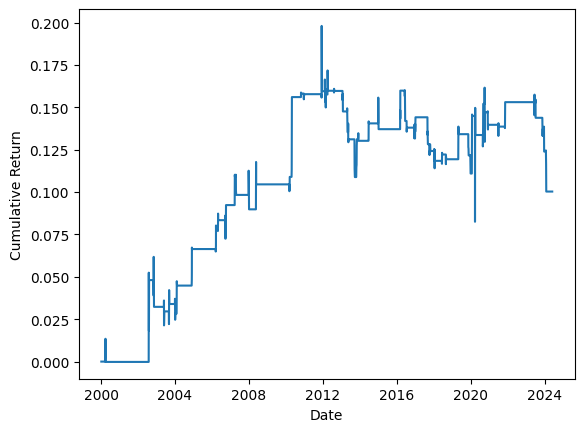

Cumulative Return : 0.10032601205054459


In [3]:
plt.plot(cumsum)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()
print(f"Cumulative Return : {cumsum[-1]}")


# Final thoughts:

0. I have no idea how the paper got a sharpe of above 2, did we make a mistake here?
1. This stratgey is good to capture a rare positive co-movement of VIX and S&P500, but that's it, nothing more.

